### Background: 
Subset of the data contains a product "Q" that was of particular interest to the company. During a marketing campaign, it was one of the most frequently offered products globally and received different responses depending on the country.
### Purpose:
Determine the optimal offer price for the product in each country.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# 'reducedQ' dataframe only has users who were offered a single Q product
df_red = pd.read_pickle('df_clean-2018-03-16-reducedQ')

In [3]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462919 entries, 0 to 462918
Data columns (total 68 columns):
ID                              462919 non-null object
Class                           40865 non-null object
InstallDate                     462919 non-null datetime64[ns]
LastSavedUTC                    462919 non-null object
LastSync                        462919 non-null object
Platform                        462919 non-null object
FirstInstalledVersion           462866 non-null object
DaysSinceInstall                462919 non-null int64
SessionCount                    462919 non-null int64
ExperimentID                    462919 non-null int64
Experiment                      462919 non-null object
MinLockedBottom                 462919 non-null int64
LockedBottom                    462919 non-null int64
LockedBottomDelta               462919 non-null int64
LockedTop                       462919 non-null int64
Variation                       69186 non-null object
PriceOptio

In [4]:
# Drop features that won't be used in model for now
df_red.drop(['Class', 'InstallDate', 'LastSavedUTC', 'LastSync',
       'FirstInstalledVersion','ExperimentID', 'Experiment', 'MinLockedBottom', 'LockedBottom',
       'LockedBottomDelta', 'LockedTop', 'Variation', 'PriceOptions', 'PriceSkus', 'Tier', 'TwoProducts', 
       'LastPurchaseDate', 'LastPurchaseDaysSinceInstall', 'LastDiscount','LastExpired', 
       'FirstAvailableStoreProduct', 'AvailableStoreProducts','FirstPrice', 'Feedback.FirstRating', 
       'Feedback.RatingCount','Feedback.LastRating', 'LastOnboardingScreen', 'PriceStrategy',
       'ActionUnlockRequestCount', 'ActionUnlockRequestValue','FailedDBRequests', 'InstalledDBVersion', 
       'SelectedTotal', 'HeightUnit', 'WeightUnit', 'EnergyUnit','OnboardingGoal'], axis=1, inplace=True)

### Pivot table on language, QProductAmtOffer with aggregated rows of QProductAmtOffer < 200 removed

In [6]:
# filter out aggregated rows with QProductAmtOffer less than 200 offers
def filter_func(x):
    return x['QProductAmtOffer'].value_counts() > 200

In [9]:
# Remove rows with total QProductAmtOffer value counts < 200
# Language is a proxy for country
Qproduct_by_language_red = pd.pivot_table(df_red.groupby(['Language','QProductAmtOffer']).filter(filter_func),
                                      index=['Language','QProductAmtOffer'], values='QProductAmtPaid', 
                                          aggfunc= ('count','mean'))

In [10]:
def language_plot(language):
    data = Qproduct_by_language_red.loc[language]
    plt.plot(data.index, data.values)

In [10]:
# Only interested in the top 20 countries with most users
top_20_languages = df_red['Language'].value_counts().head(20).index.tolist()

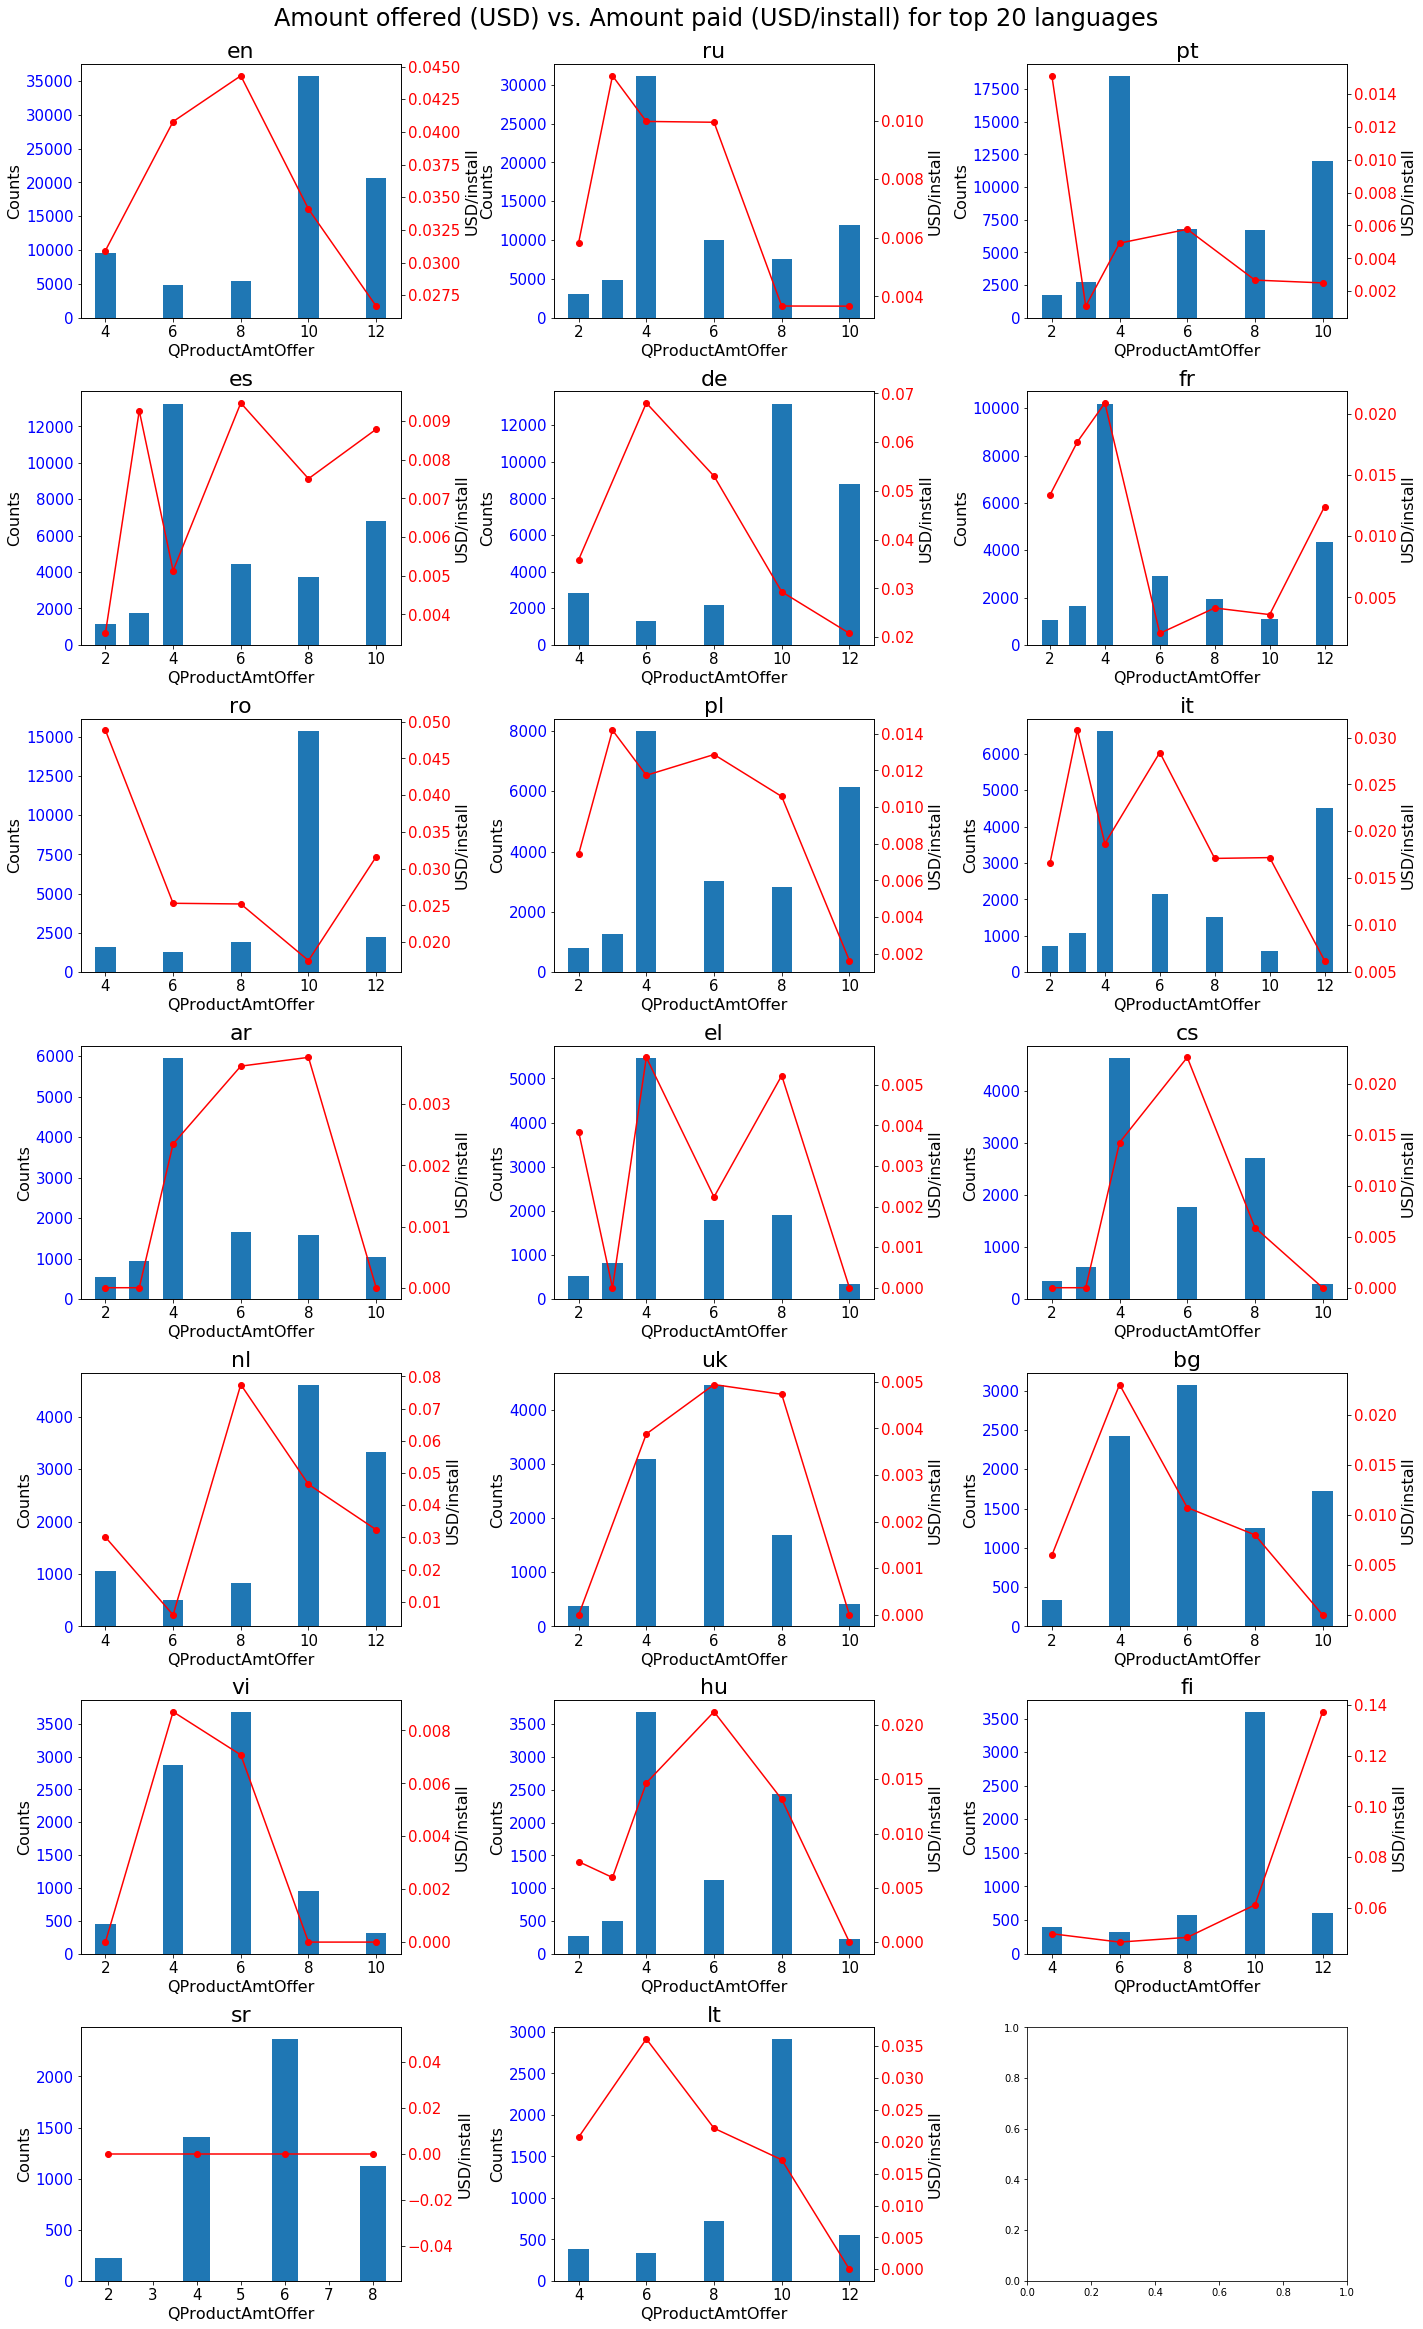

In [11]:
# Plot counts and amount paid per install

fig,ax = plt.subplots(7,3, figsize=(20,34))
plt.suptitle('Amount offered (USD) vs. Amount paid (USD/install) for top 20 languages', fontsize=24)
ax = ax.ravel()

for i in range(len(top_20_languages)):
    data = Qproduct_by_language_red.loc[top_20_languages[i]]
    ax2 = ax[i].twinx()
    ax[i].set_title(top_20_languages[i], fontsize=22)
    ax[i].set_xlabel('QProductAmtOffer', fontsize=16)
    ax[i].set_ylabel('Counts', fontsize=16)
    ax[i].bar(data.index, data['count'], width=0.6)
    ax[i].tick_params(axis='y', labelcolor='blue', labelsize=15)
    ax[i].tick_params(axis='x', labelsize=15)

    ax2.set_ylabel('USD/install', fontsize=16)
    ax2.plot(data.index, data['mean'], '-or')
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#plt.savefig('Qproduct_by_language_counts.png')

### Regression on pivoted data: Language, QProductAmtPaid

In [12]:
# Save pivoted data as dataframe with all records filled in
#pd.set_option('display.max_rows', 500)
df_Q = pd.DataFrame(Qproduct_by_language_red.to_records())

In [15]:
df_en = df_Q[df_Q['Language']=='en'].reset_index(drop=True)

In [16]:
df_en

,Language,QProductAmtOffer,count,mean
0,en,4,9575,0.030914
1,en,6,4781,0.040786
2,en,8,5464,0.044290
3,en,10,35667,0.034093
4,en,12,20627,0.026664


In [27]:
swen = df_en['count'].tolist()

In [28]:
swen

[9575, 4781, 5464, 35667, 20627]

In [17]:
poly = PolynomialFeatures(degree=2)
linreg = LinearRegression()

In [18]:
Xen = df_en[['QProductAmtOffer']]
yen = df_en[['mean']]

In [24]:
Xen

,QProductAmtOffer
0,4
1,6
2,8
3,10
4,12


In [21]:
Xen_poly= poly.fit_transform(df_en[['QProductAmtOffer']])

In [22]:
Xen_poly

array([[   1.,    4.,   16.],
       [   1.,    6.,   36.],
       [   1.,    8.,   64.],
       [   1.,   10.,  100.],
       [   1.,   12.,  144.]])

In [29]:
yen_fit = linreg.fit(Xen_poly, yen, sample_weight=swen)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
df_dict = {}

for i in range(0, len(top_20_languages)):
    df_dict[i] = df_Q[df_Q['Language']==top_20_languages[i]].reset_index(drop=True)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sp
from scipy import optimize

Language: en
Intercept: [ 0.00282464]
Coefficients: [[ 0.          0.00996346 -0.00067094]]
Optimization terminated successfully.
         Current function value: -0.039814
         Iterations: 31
         Function evaluations: 62
Maximum: [ 7.4250625]


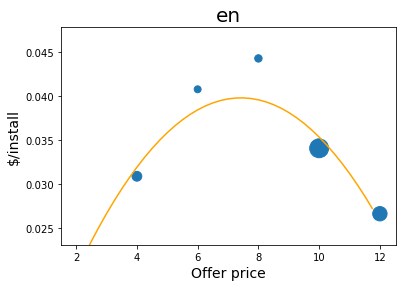

Language: ru
Intercept: [ 0.00710736]
Coefficients: [[ 0.          0.00141616 -0.00018424]]
Optimization terminated successfully.
         Current function value: -0.009829
         Iterations: 29
         Function evaluations: 58
Maximum: [ 3.8431875]


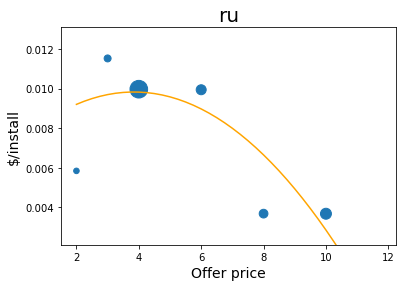

Language: pt
Intercept: [ 0.01080025]
Coefficients: [[  0.00000000e+00  -1.71787310e-03   9.05066139e-05]]
Maximum: [ -3.16912650e+26]


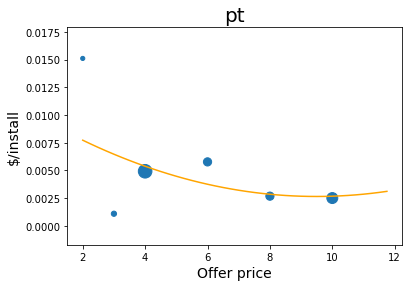

Language: es
Intercept: [ 0.00134806]
Coefficients: [[  0.00000000e+00   1.46931524e-03  -7.31131658e-05]]
Optimization terminated successfully.
         Current function value: -0.008730
         Iterations: 31
         Function evaluations: 62
Maximum: [ 10.04825]


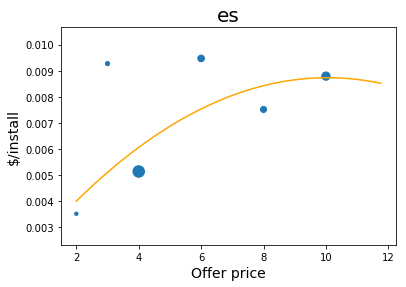

Language: de
Intercept: [ 0.01578781]
Coefficients: [[ 0.          0.00987116 -0.00080805]]
Optimization terminated successfully.
         Current function value: -0.045934
         Iterations: 30
         Function evaluations: 60
Maximum: [ 6.108]


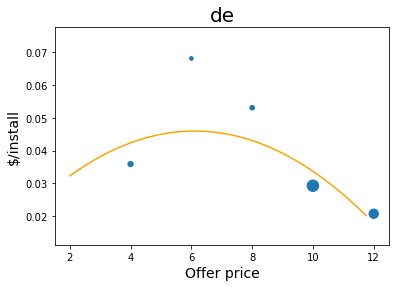

Language: fr
Intercept: [ 0.04257668]
Coefficients: [[ 0.         -0.00845875  0.00048712]]
Maximum: [ -3.16912650e+26]


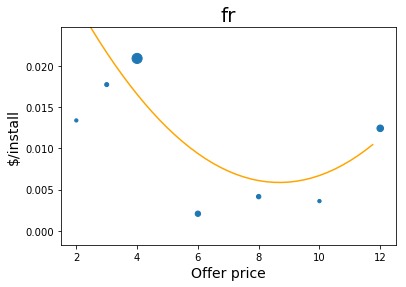

Language: ro
Intercept: [ 0.12257992]
Coefficients: [[ 0.         -0.02367294  0.00132563]]
Maximum: [ -3.16912650e+26]


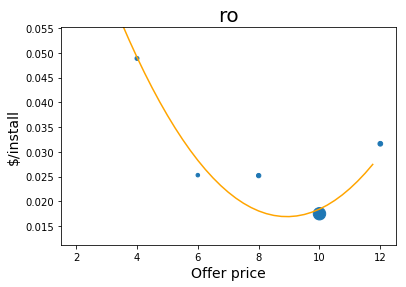

Language: pl
Intercept: [-0.00059941]
Coefficients: [[ 0.          0.0052672  -0.00050195]]
Optimization terminated successfully.
         Current function value: -0.013218
         Iterations: 30
         Function evaluations: 60
Maximum: [ 5.24675]


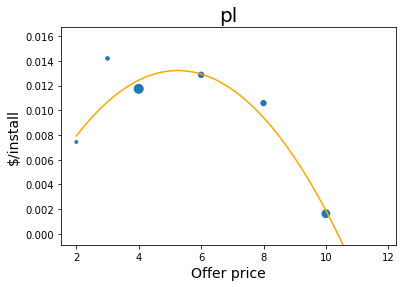

Language: it
Intercept: [ 0.01033159]
Coefficients: [[ 0.          0.00440207 -0.00039485]]
Optimization terminated successfully.
         Current function value: -0.022601
         Iterations: 30
         Function evaluations: 60
Maximum: [ 5.5743125]


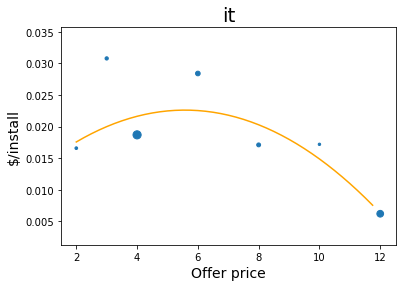

Language: ar
Intercept: [-0.0068718]
Coefficients: [[ 0.          0.00336016 -0.00026308]]
Optimization terminated successfully.
         Current function value: -0.003858
         Iterations: 30
         Function evaluations: 60
Maximum: [ 6.38625]


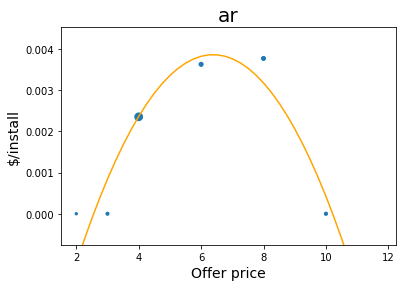

Language: el
Intercept: [ 0.00034751]
Coefficients: [[ 0.          0.00170144 -0.00015749]]
Optimization terminated successfully.
         Current function value: -0.004943
         Iterations: 30
         Function evaluations: 60
Maximum: [ 5.4019375]


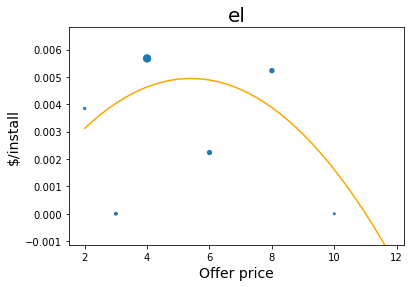

Language: cs
Intercept: [-0.03248292]
Coefficients: [[ 0.          0.01794697 -0.00158753]]
Optimization terminated successfully.
         Current function value: -0.018240
         Iterations: 30
         Function evaluations: 60
Maximum: [ 5.6525]


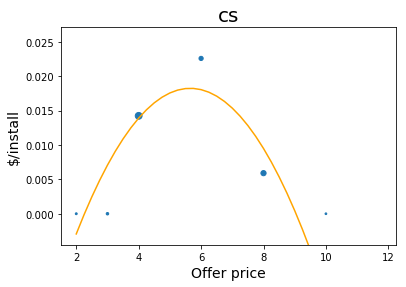

Language: nl
Intercept: [-0.05208214]
Coefficients: [[ 0.          0.02511651 -0.00150781]]
Optimization terminated successfully.
         Current function value: -0.052513
         Iterations: 31
         Function evaluations: 62
Maximum: [ 8.3288125]


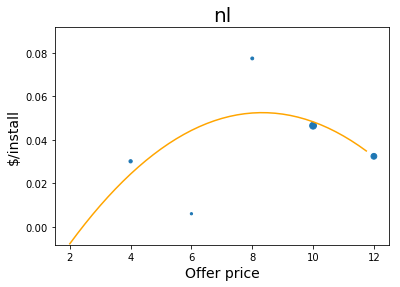

Language: uk
Intercept: [-0.00614959]
Coefficients: [[ 0.          0.00367378 -0.00029817]]
Optimization terminated successfully.
         Current function value: -0.005167
         Iterations: 30
         Function evaluations: 60
Maximum: [ 6.1605625]


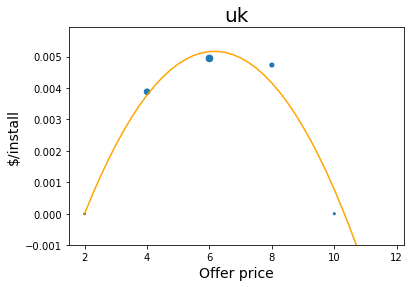

Language: bg
Intercept: [ 0.01935356]
Coefficients: [[ 0.          0.0007496  -0.00027654]]
Optimization terminated successfully.
         Current function value: -0.019862
         Iterations: 26
         Function evaluations: 52
Maximum: [ 1.3553125]


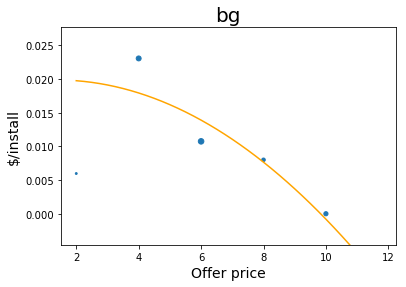

Language: vi
Intercept: [-0.00378817]
Coefficients: [[ 0.          0.00475714 -0.0004872 ]]
Optimization terminated successfully.
         Current function value: -0.007824
         Iterations: 29
         Function evaluations: 58
Maximum: [ 4.882125]


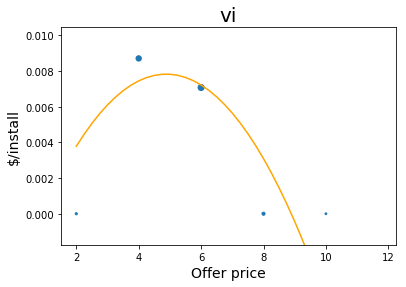

Language: hu
Intercept: [-0.0202837]
Coefficients: [[ 0.          0.01338582 -0.00114257]]
Optimization terminated successfully.
         Current function value: -0.018922
         Iterations: 30
         Function evaluations: 60
Maximum: [ 5.85775]


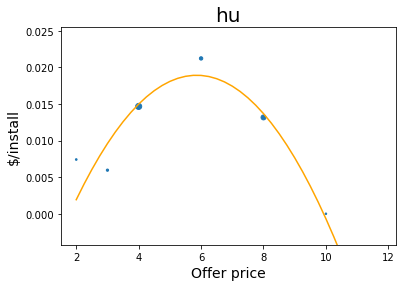

Language: fi
Intercept: [ 0.20205049]
Coefficients: [[ 0.         -0.05042069  0.00367784]]
Maximum: [ -3.16912650e+26]


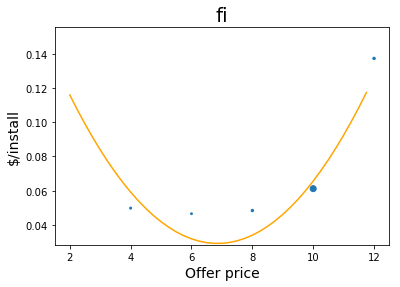

Language: sr
Intercept: [ 0.]
Coefficients: [[ 0.  0.  0.]]
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 8
Maximum: [ 0.]


/Users/angielin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


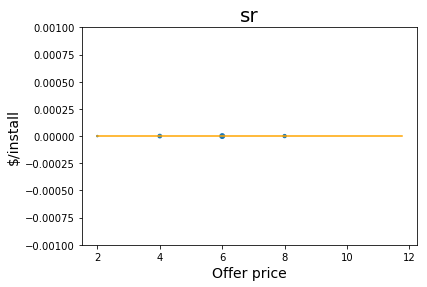

Language: lt
Intercept: [-0.00932574]
Coefficients: [[ 0.          0.01169781 -0.00090872]]
Optimization terminated successfully.
         Current function value: -0.028320
         Iterations: 30
         Function evaluations: 60
Maximum: [ 6.436375]


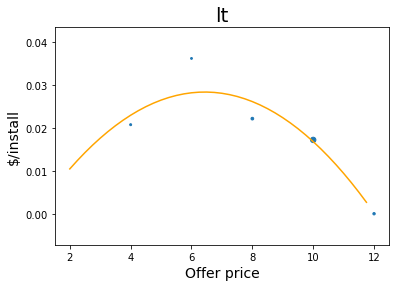

In [122]:
poly = PolynomialFeatures(degree=2)
linreg = LinearRegression()

for i in range(0, len(top_20_languages)):
    sw = df_dict[i]['count'].tolist()
    sw_marker = [x/100 for x in sw]
    X = df_dict[i][['QProductAmtOffer']]
    X_poly= poly.fit_transform(df_dict[i][['QProductAmtOffer']])
    y = df_dict[i][['mean']]
    y_fit = linreg.fit(X_poly, y, sample_weight=sw)
    print('Language:', top_20_languages[i])
    print('Intercept:', linreg.intercept_)
    print('Coefficients:', linreg.coef_)
    
    # Find maximum
    def f(x):
        return linreg.intercept_[0]+linreg.coef_[0][0]+linreg.coef_[0][1]*x+linreg.coef_[0][2]*x**2
    
    max_x = sp.optimize.fmin(lambda x: -f(x), 0)
    print('Maximum:', max_x)
    
    # Plot
    plt.scatter(X, y, s=sw_marker)
    x = np.arange(2,12,0.25)
    plt.plot(x, linreg.intercept_[0]+linreg.coef_[0][0]+linreg.coef_[0][1]*x+linreg.coef_[0][2]*x**2, color='orange')
    dy = (max(df_dict[i]['mean'])-min(df_dict[i]['mean']))*0.2
    plt.ylim(min(df_dict[i]['mean'])-dy, max(df_dict[i]['mean'])+dy)
    plt.title(top_20_languages[i], fontsize=20)
    plt.xlabel('Offer price', fontsize=14)
    plt.ylabel('$/install', fontsize=14)
    plt.show()

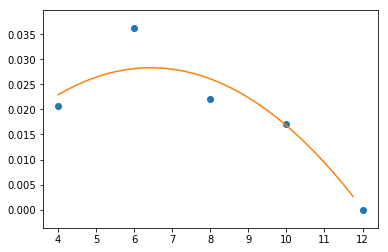

In [112]:
plt.plot(X, y, 'o')
x = np.arange(4,12,0.25)
plt.plot(x, linreg.intercept_[0]+linreg.coef_[0][0]+linreg.coef_[0][1]*x+linreg.coef_[0][2]*x**2)
dy = (max(df_dict[i]['mean'])-min(df_dict[i]['mean']))*0.1
plt.ylim(min(df_dict[i]['mean'])-dy, max(df_dict[i]['mean'])+dy)
plt.show()

In [111]:
max(df_dict[i]['mean'])

0.03614457831325301

In [85]:
import scipy as sp
from scipy import optimize

In [86]:
def f(x):
    return linreg.intercept_[0]+linreg.coef_[0][0]+linreg.coef_[0][1]*x+linreg.coef_[0][2]*x**2+linreg.coef_[0][3]*x**3

In [87]:
max_x = sp.optimize.fmin(lambda x: -f(x), 0)

Optimization terminated successfully.
         Current function value: -0.043347
         Iterations: 30
         Function evaluations: 60


In [88]:
max_x

array([ 6.981125])

### weighted regression (w/ sample weights)

In [130]:
# scale down 'count' by 100 to use as marker size points
sw = df_en['count'].tolist()
sw_small = [x/100 for x in sw]

In [132]:
#clf.fit(X, y, sample_weight=sample_weight)

linreg.fit(X_poly, y, sample_weight=sw)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [134]:
linreg.coef_

array([ 0.        ,  0.00996346, -0.00067094])

In [135]:
linreg.intercept_

0.0028246445491399708

In [136]:
def f(x):
    return linreg.intercept_+linreg.coef_[0]+linreg.coef_[1]*x+linreg.coef_[2]*x**2

In [137]:
max_x = sp.optimize.fmin(lambda x: -f(x), 0)
max_x

Optimization terminated successfully.
         Current function value: -0.039814
         Iterations: 31
         Function evaluations: 62


array([ 7.4250625])

(0.025, 0.0475)

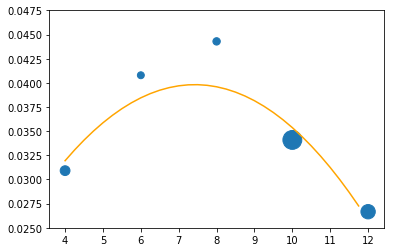

In [142]:
plt.scatter(X, y, s=sw_small)
x = np.arange(4,12,0.25)
plt.plot(x, linreg.intercept_+linreg.coef_[1]*x+linreg.coef_[2]*x**2, color='orange')
plt.ylim(0.0250, 0.0475)

### Pivot table by AgeWhenGoalsSet, QProductAmtOffer

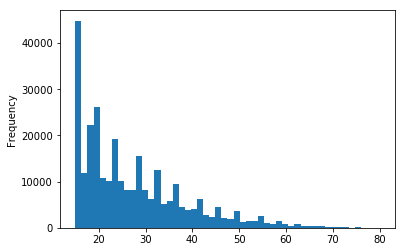

In [67]:
# group age by quintile distribution
df_red[df_red['AgeWhenGoalsSet']!=0]['AgeWhenGoalsSet'].plot.hist(bins=50)

In [71]:
df_red[df_red['AgeWhenGoalsSet']!=0]['AgeWhenGoalsSet'].count()

285632

In [81]:
df_age = df_red[df_red['AgeWhenGoalsSet']!=0].reset_index()

In [117]:
quintiles = pd.qcut(df_age['AgeWhenGoalsSet'], 5, labels=[1,2,3,4,5])
df_age = df_age.assign(AgeGroup=quintiles.values)

In [119]:
df_age['AgeGroup'] = df_age['AgeGroup'].astype(int)

In [137]:
Qproduct_by_age = pd.pivot_table(df_age, index=['AgeGroup', 'QProductAmtOffer'], values='QProductAmtPaid',
                                aggfunc=('count', 'mean'))

In [138]:
Qproduct_by_age

count      mean
AgeGroup QProductAmtOffer                 
1        2                  2332  0.000858
         3                  2914  0.004461
         4                 24410  0.002294
         6                 12859  0.002644
         8                 10332  0.003291
         10                20191  0.003467
         12                 6031  0.003979
2        2                  1041  0.007685
         3                  1316  0.002280
         4                 11461  0.006631
         6                  5943  0.003029
         8                  4777  0.008792
         10                 9183  0.007623
         12                 3108  0.000000
3        2                  1574  0.005083
         3                  1982  0.009082
         4                 17282  0.016202
         6                  8336  0.020873
         8                  7271  0.007702
         10                14487  0.025816
         12                 4933  0.023515
4        2                  1670  0.026347
         3                  2065  0.030993
         4                 18346  0.025074
         6                  8146  0.029831
         8                  7504  0.018923
         10                15421  0.038130
         12                 5371  0.032024
5        2                  1278  0.031299
         3                  1693  0.021855
         4                 15961  0.042854
         6                  7005  0.052677
         8                  6680  0.067066
         10                14917  0.079574
         12                 7812  0.076805

In [143]:
age_groups = ['15-18', '19-21', '22-27', '28-36', '37-80']

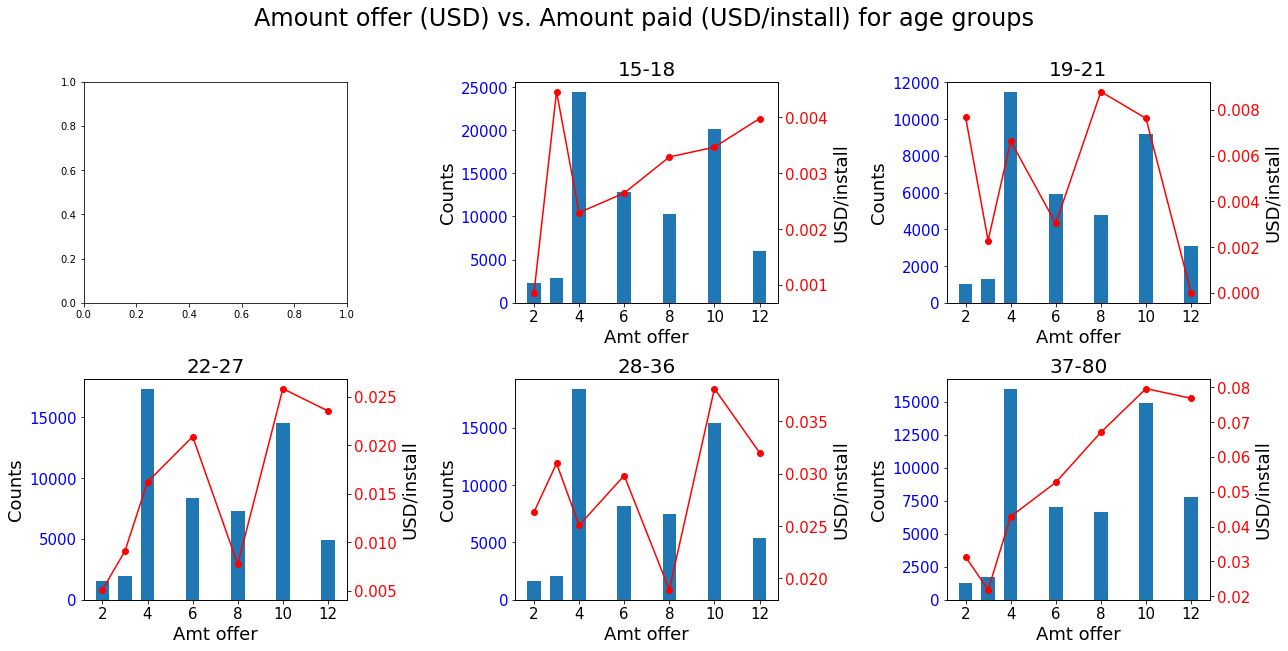

In [153]:
fig, ax = plt.subplots(2,3, figsize=(18,10))
plt.suptitle('Amount offer (USD) vs. Amount paid (USD/install) for age groups', fontsize=24)
ax = ax.ravel()

for i in range(1, df_age['AgeGroup'].nunique()+1):
    data = Qproduct_by_age.loc[i]
    ax[i].bar(data.index, data['count'], width=0.6)
    ax[i].set_title(age_groups[i-1], fontsize=20)
    ax[i].set_xlabel('Amt offer', fontsize=18)
    ax[i].set_ylabel('Counts', fontsize=18)
    ax[i].tick_params(axis='y', labelcolor='blue', labelsize=15)
    ax[i].tick_params(axis='x', labelsize=15)
    
    ax2 = ax[i].twinx()
    ax2.plot(data.index, data['mean'], '-or')
    ax2.set_ylabel('USD/install', fontsize=18)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    
plt.tight_layout(rect=[0, 0.08, 1, 0.92])
plt.savefig('Qproduct_by_age.png')

In [ ]:
# one hot encoding for UICulture of top 20 cultures, Gender
# multivariate regression on UICulture, Gender, (AgeWhenGoalsSet), QProductAmtOffer to target QProductAmtPaid
# add WeightDiff, Program, ShowMealTime

### One hot encoding

In [156]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462919 entries, 0 to 462918
Data columns (total 22 columns):
ID                   462919 non-null object
DaysSinceInstall     462919 non-null int64
SessionCount         462919 non-null int64
SingleProduct        462919 non-null object
UICulture            462919 non-null object
Language             462919 non-null object
IsPaid               462919 non-null bool
LastProduct          462919 non-null object
LastProductValue     462919 non-null float64
TotalValue           462919 non-null float64
Gender               462919 non-null object
AgeWhenGoalsSet      462919 non-null int64
DailyGoalCount       462919 non-null int64
Program              462919 non-null object
ReminderFrequency    462919 non-null object
ShowMealTime         462919 non-null bool
ExerciseFrequency    462919 non-null object
Height               462919 non-null float64
LastWeight           462919 non-null float64
TargetWeight         462919 non-null float64
QProductAmtO

In [80]:
#df = df.reset_index(drop=True)

In [97]:
df_red['QProductAmtPaid'].describe()

count    462919.000000
mean          0.016703
std           0.370547
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: QProductAmtPaid, dtype: float64

In [102]:
df_red[(df_red['QProductAmtPaid']>0) &
       (df_red['UICulture']=='en-US')]['QProductAmtPaid'].describe()

count    180.000000
mean       7.827778
std        3.163745
min        2.000000
25%        4.000000
50%       10.000000
75%       10.000000
max       12.000000
Name: QProductAmtPaid, dtype: float64

In [103]:
df_red.drop(['ID', 'Class', 'InstallDate', 'LastSavedUTC', 'LastSync', 'Platform',
       'FirstInstalledVersion', 'DaysSinceInstall', 'SessionCount',
       'ExperimentID', 'Experiment', 'MinLockedBottom', 'LockedBottom',
       'LockedBottomDelta', 'LockedTop', 'Variation', 'PriceOptions',
       'PriceSkus', 'Tier', 'OfferFree', 'SingleProduct', 'TwoProducts',
       'Language', 'IsPaid', 'LastProduct', 'LastProductValue',
       'LastPurchaseDate', 'LastPurchaseDaysSinceInstall', 'LastDiscount',
       'LastExpired', 'FirstAvailableStoreProduct', 'AvailableStoreProducts',
       'FirstPrice', 'Feedback.FirstRating', 'Feedback.RatingCount',
       'Feedback.LastRating', 'LastOnboardingScreen', 'PriceStrategy',
       'ActionUnlockRequestCount', 'ActionUnlockRequestValue',
       'FailedDBRequests', 'TotalValue', 'InstalledDBVersion',
       'AgeWhenGoalsSet',
       'SelectedTotal', 'ShowMealTime', 'ExerciseFrequency', 'Height',
       'LastWeight', 'HeightUnit', 'WeightUnit', 'EnergyUnit',
       'OnboardingGoal', 'WeightDiff', 'LastBMI', 'TargetBMI',
       'SessionsPerDay', 'AgeCategory'], axis=1, inplace=True)

In [109]:
df_red.drop(['Program','ReminderFrequency'], axis=1, inplace=True)

In [111]:
df_cat = pd.get_dummies(df_red[['UICulture','Gender']], columns=['UICulture', 'Gender'], prefix=['Culture','Gender'], drop_first=True)

In [123]:
df_red.drop(['UICulture','Gender'], axis=1, inplace=True)

In [113]:
df_cat.head()

,Culture_ar,Culture_ar-AE,Culture_ar-BH,Culture_ar-DZ,Culture_ar-EG,Culture_ar-IQ,Culture_ar-JO,Culture_ar-KW,Culture_ar-LB,Culture_ar-LY,...,Culture_vi,Culture_vi-VN,Culture_zh,Culture_zh-CN,Culture_zh-HK,Culture_zh-Hant,Culture_zh-SG,Culture_zh-TW,Gender_Male,Gender_None
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [124]:
df_new = pd.concat([df_cat, df_red], axis=1)

In [125]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462919 entries, 0 to 462918
Columns: 177 entries, Culture_ar to QProductAmtPaid
dtypes: float64(1), int64(3), uint8(173)
memory usage: 90.5 MB


In [117]:
### scale QProductAmtOffer and QProductAmtPaid
from sklearn.preprocessing import MinMaxScaler

In [118]:
scaler = MinMaxScaler()

In [ ]:
# create polynomial features
#from sklearn.preprocessing import PolynomialFeatures

In [119]:
from sklearn.model_selection import train_test_split

In [126]:
X = df_new.drop(['QProductAmtPaid'], axis=1)
y = df_new['QProductAmtPaid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Scale X training and test data by fitting X training data
- scale QProductAmtOffer, turn outputed array back to dataframe and concatenate with main train/test dataframes
- drop QProductAmtOffer, keeping only the scaled column

In [27]:
# fit_transform only takes a pandas dataframe and outputs scaled numpy array
X_train_Q_scaled = scaler.fit_transform(X_train[['QProductAmtOffer']])
X_test_Q_scaled = scaler.transform(X_test[['QProductAmtOffer']])

In [28]:
# turn scaled array back into dataframe and concatenate with categorical features
X_train_Q_scaled = pd.DataFrame(X_train_Q_scaled, index=X_train.index, columns=['QProductAmtOffer_scale'])

In [30]:
X_train_scaled = pd.concat([X_train, X_train_Q_scaled], axis=1)

In [34]:
X_test_Q_scaled = pd.DataFrame(X_test_Q_scaled, index=X_test.index, columns=['QProductAmtOffer_scale'])
X_test_scaled = pd.concat([X_test, X_test_Q_scaled], axis=1)

In [36]:
X_train_scaled.drop('QProductAmtOffer', axis=1, inplace=True)
X_test_scaled.drop('QProductAmtOffer', axis=1, inplace=True)

### Regression models

In [38]:
# Linear regression with L2 regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [39]:
linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

In [40]:
print('Ridge regression on UICulture, Gender, QProductAmtOffer')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Ridge regression on UICulture, Gender, QProductAmtOffer
ridge regression linear model intercept: 0.017632015328592467
ridge regression linear model coeff:
[-0.0037635   0.01523245 -0.01044302  0.00570449  0.01673421  0.02806096
 -0.00789933 -0.00368809  0.05476234 -0.00351882  0.00013389  0.00405982
  0.03552019 -0.00439445 -0.00949484  0.01431495 -0.00463481 -0.0075765
 -0.00903271  0.03592653 -0.01149551 -0.00795681]
R-squared score (training): 0.002
R-squared score (test): 0.002
Number of non-zero features: 22


In [121]:
# Decision tree regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [131]:
regr_1 = DecisionTreeRegressor(max_depth=30, random_state=0)
regr_2 = DecisionTreeRegressor(max_depth=50, random_state=0)
regr_3 = DecisionTreeRegressor(max_depth=100, random_state=0)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [132]:
print('Accuracy of Decision Tree regressor 1 on training set: {:.2f}'
     .format(regr_1.score(X_train, y_train)))
print('Accuracy of Decision Tree regressor 1 on test set: {:.2f}'
     .format(regr_1.score(X_test, y_test)))
print('Accuracy of Decision Tree regressor 2 on training set: {:.2f}'
     .format(regr_2.score(X_train, y_train)))
print('Accuracy of Decision Tree regressor 2 on test set: {:.2f}'
     .format(regr_2.score(X_test, y_test)))
print('Accuracy of Decision Tree regressor 3 on training set: {:.2f}'
     .format(regr_3.score(X_train, y_train)))
print('Accuracy of Decision Tree regressor 3 on test set: {:.2f}'
     .format(regr_3.score(X_test, y_test)))

Accuracy of Decision Tree regressor 1 on training set: 0.36
Accuracy of Decision Tree regressor 1 on test set: -0.32
Accuracy of Decision Tree regressor 2 on training set: 0.40
Accuracy of Decision Tree regressor 2 on test set: -0.37
Accuracy of Decision Tree regressor 3 on training set: 0.40
Accuracy of Decision Tree regressor 3 on test set: -0.36
